# House Prices Sales Prediction - Gianmaria Pizzo



The aforementioned process follows the following steps:

Import Dataset, Headers & Libraries.
Identify Missing Data.
Replace Missing Data.
Evaluate Missing Data.
Dealing with Missing Data.
Correct Data Formats.
Data standardization.
Binning.
Data Normalization.
Indicator variable.

## Environment Set Up

In [10]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits

# 1 - Basic Exploration

## Dataset Loading

In [83]:
data = arff.loadarff(r'C:\Users\PayThePizzo\PycharmProjects\pythonProject\resources\ames_housing.arff')
df = pd.DataFrame(data[0])

df.shape

(2930, 81)

We have 2930 objects and 81 columns! That is a lot of data for each single object, we need to find out what are the best ones for the job.

Furthermore, we will need to isolate/hide the sales price in order to avoid overfitting!

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   float64
 3   Lot_Area            2930 non-null   float64
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

The dataset appears to be very complete, and ready to work with. It has **0 missing information**!

The features are mostly objects
* 35 `float64`
* 46 `object`

We need to plan for encoding and studying what features can be determinant factors (domain knowledge)


In [85]:
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',141.0,31770.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,5.0,2010.0,b'WD ',b'Normal',215000.0,-93.619754,42.054035
1,b'One_Story_1946_and_Newer_All_Styles',b'Residential_High_Density',80.0,11622.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,6.0,2010.0,b'WD ',b'Normal',105000.0,-93.619756,42.053014
2,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',81.0,14267.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'Gar2',12500.0,6.0,2010.0,b'WD ',b'Normal',172000.0,-93.619387,42.052659
3,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',93.0,11160.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,4.0,2010.0,b'WD ',b'Normal',244000.0,-93.617320,42.051245
4,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',74.0,13830.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,3.0,2010.0,b'WD ',b'Normal',189900.0,-93.638933,42.060899


In [88]:
# Geographic Map

BBox = ((df.Longitude.min(), df.Longitude.max()),
         df.Latitude.min(), df.Latitude.max())
BBox

# Let's get the image from https://www.openstreetmap.org/export#map=5/51.500/-0.100
# Or plot with python 



((-93.693153, -93.577427), 41.986498, 42.063388)

In [ ]:
#Save all float64 to new df_numeric
#Save all object to new df_obj


Let us have a quick look at the Sales Prices. In order to add significance to the graph we want to use the colors to indicate the lot of area, and the markers to classify the type of neighborhood.

<IPython.core.display.Javascript object>


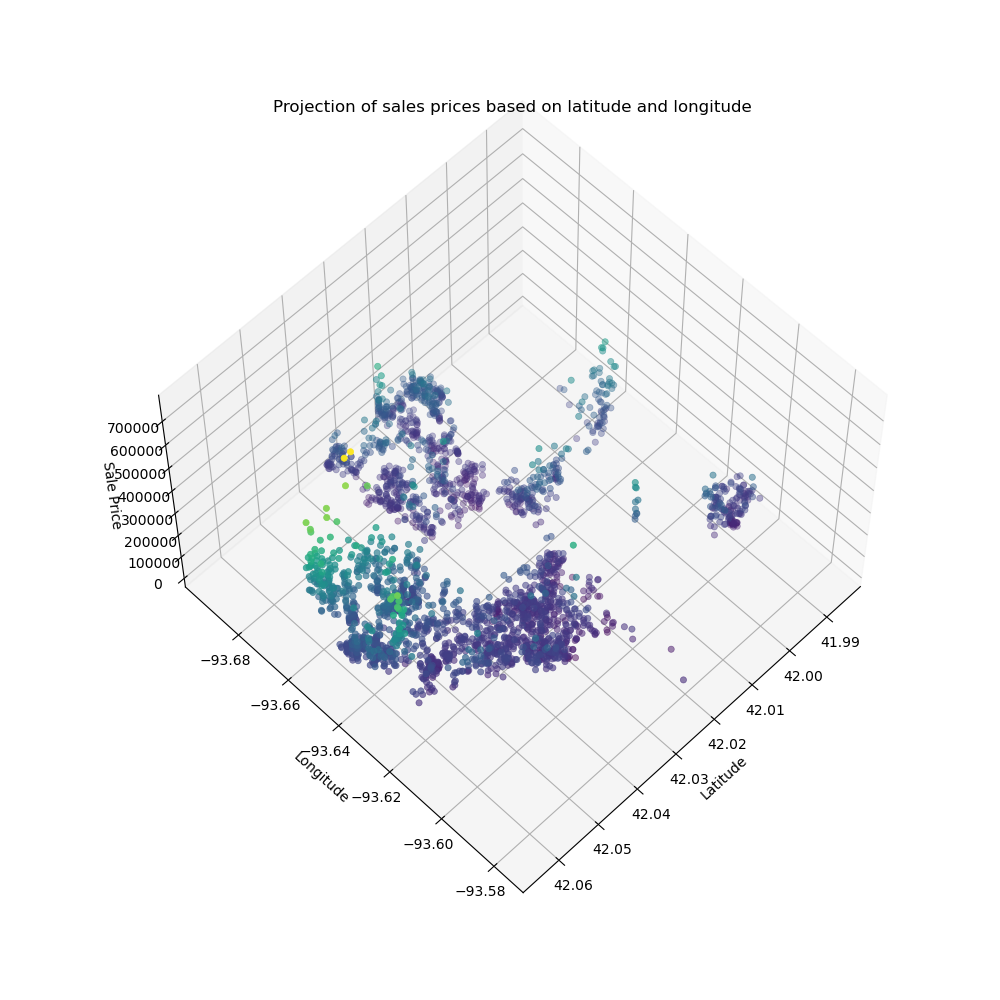

In [12]:
from mpl_toolkits.mplot3d import axes3d

z = df.Sale_Price
x = df.Latitude
y = df.Longitude

# TODO
# marker = Neighborhood
# color = lot_area
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='viridis', linewidths=0.5)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Sale Price')
ax.set_title('Projection of sales prices based on latitude and longitude')

plt.show()

In [ ]:
# Remove outliers